### Written by  [Gabriel Borges Pinheiro](github.com/gabrielbopi) & Wissam Melo

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [2]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [3]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [4]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(num_ue):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [5]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Number of users
num_ue = 3

total,BS = bases(gap_bs, 200, 100)
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
BSUE = BSs_per_UE(BS, UE, total)

In [6]:
BS

array([[ 25.,  25.,  15.],
       [ 75.,  25.,  15.],
       [125.,  25.,  15.],
       [175.,  25.,  15.],
       [ 25.,  75.,  15.],
       [ 75.,  75.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]])

In [7]:
UE

array([[116.21070319,  74.10612159,   1.5       ],
       [156.80768949,  68.31576088,   1.5       ],
       [117.65230052,   4.0235015 ,   1.5       ]])

In [8]:
UEs_antenna

[array([], shape=(0, 3), dtype=float64),
 array([[117.65230052,   4.0235015 ,   1.5       ]]),
 array([[117.65230052,   4.0235015 ,   1.5       ]]),
 array([[156.80768949,  68.31576088,   1.5       ]]),
 array([], shape=(0, 3), dtype=float64),
 array([[116.21070319,  74.10612159,   1.5       ]]),
 array([[116.21070319,  74.10612159,   1.5       ],
        [156.80768949,  68.31576088,   1.5       ]]),
 array([[156.80768949,  68.31576088,   1.5       ]])]

In [9]:
UEs_antenna[2].shape[0]

1

In [10]:
BSUE

array([array([[ 75.,  75.,  15.],
       [125.,  75.,  15.]]),
       array([[175.,  25.,  15.],
       [125.,  75.,  15.],
       [175.,  75.,  15.]]),
       array([[ 75.,  25.,  15.],
       [125.,  25.,  15.]])], dtype=object)

#### Calculating the parameters

In [11]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [104]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def ch_user(N, num_ue, UE, total, BSUE):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    
    h = np.zeros((num_ue,total,N),dtype = 'complex_')
    for i in range(num_ue):
        for j in range(BSUE[i].shape[0]):
            R = np.linalg.norm(UE[i] - BSUE[i][j])
            h[i][j] = rand_channel(R, N)
    return h

def channel_user2(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for ii in range(numBS):
        for jj in range(UEs_antenna[ii].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[ii][jj] - UEpos),axis=1))
            R = np.linalg.norm(BSpos[ii] - UEs_antenna[ii][jj]) 
            H[int(user)][ii] = rand_channel(R, nAntennas)

    return H

def channel_user(N, UE, num_ue, BSs_per_UE):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    
    num_ue = BSs_per_UE.shape[0]
    h = np.array([])
    y = np.array([])
    for i in range(num_ue):
        for j in range(BSs_per_UE[i].shape[0]):
            R = np.linalg.norm(UE[i] - BSs_per_UE[i][j])
            y = rand_channel(R, N)
            h = np.append(h, y)
        h = np.append(h, 0)
    
    size = len(h) 
    idx_list = [idx + 1 for idx, val in enumerate(h) if val == 0] 
    h = [h[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    for i in range(len(h)):
        indices = np.where(h[i]==0)
        h[i] = np.delete(h[i], indices)
        #h[i] = h[i].reshape(int((h[i].shape[0])/N),N)
    h = np.array(h)
    
    return h

def powerUE(num_ue, total, UEpos,UEs_antenna, P_dBm):
    p = np.zeros(num_ue)
    for i in range(total):
        UE_BS = UEs_antenna[i].shape[0]
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            p[int(user)] =  p[int(user)] + (inv_dbm(P_dBm)/int(UE_BS))
    return dbm(p)

def get_beamforming(h, num_ue, total, P_dBm):
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total*N), dtype = 'complex_')
    for i in range(num_ue):
        v[i] = np.sqrt(p[i])*(np.conjugate(h[i])/np.linalg.norm(h[i]))
        
    return v

In [105]:
P_dBm = 40
powerUE(num_ue, total, UE,UEs_antenna, P_dBm)

array([41.76091259, 43.97940009, 43.01029996])

In [95]:
#Numero de antenas no arranjo
N = 5

#h = channel_user(N, UE, total, BSUE)
H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)

In [96]:
len(H)

3

In [97]:
BSUE[0].shape[0]

2

In [98]:
def vectorize(H, num_ue, total, N):
    h = np.zeros((num_ue, N*total), dtype ='complex_')
    for i in range(num_ue):
        h[i] = H[i].reshape(N*total)
    return h

H = vectorize(H, 3, total, N)

In [99]:
v = get_beamforming(H, num_ue, total, P_dBm)

In [100]:
v

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.01714585-0.57389041j,
         0.10174331-0.47953619j, -0.52192083+0.19798375j,
        -0.08531316+0.23915007j, -0.11272603+0.0128043j ,
        -1.01931802+0.66000464j,  1.44906546+1.18827699j,
        -0.70276897+1.34830151j, -1.20484559-0.1125887j ,
         0.432

In [102]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [103]:
σ

1.9952623149688826e-10

In [87]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        #if V[x]:
        if x!=j:
            #den = np.add(den, np.abs(V[x].transpose()@h)**2)
            den += np.abs(V[x].transpose()@h)**2
    return (num/(den+σ))

In [88]:
p = inv_dbm(P_dBm)
H[0].transpose() @(np.sqrt(p)*(np.conjugate(H[0])/np.linalg.norm(H[0])))

(6.580634822166953e-05+8.470329472543003e-22j)

In [89]:
H[0].transpose()@v[0]

(6.580634822166953e-05+8.470329472543003e-22j)

In [90]:
j = 0
s_inr = sinr(H[j], v, j, σ)

In [91]:
s_inr

11.2631049099004

In [92]:
print(db(s_inr))

10.516581293568848


In [93]:
S = np.zeros(len(UE))
for i in range(len(UE)):
    S[i] = sinr(H[i], v, i, σ)


In [94]:
print(np.sum(np.log2(S+1)))
#C

8.847233479879218


In [35]:
BS.shape[0]

8

In [ ]:
def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(n, x, y)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    
    H = ch_user(N, num_ue, BS, total, UEs_antenna)
    V = get_beamforming(H, num_ue, total, N)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C, sinr

In [34]:
for i in range(mc):
    np.random.seed(i)
    C, sinr = sinr_mc(num_ue, N, BS, P_dBm)

[ 2.70684984  0.62813271  0.90796945  0.50382575  0.65111795 -0.31931804
 -0.84807698  0.60596535 -2.01816824  0.74012206]


##### Main parameters

In [78]:
#Numero de antenas no arranjo
N = 5

#Tamanho das torres de BS
bs_height = 15 #m
#Espaçamento entre cada BS
gap_bs = 50 #m

#Potencia de cada base
P_t = 40 #dBm

#Number of Monte Carlo realizations
mc = 1000

#### Plotting a map

IndexError: index 2 is out of bounds for axis 0 with size 1

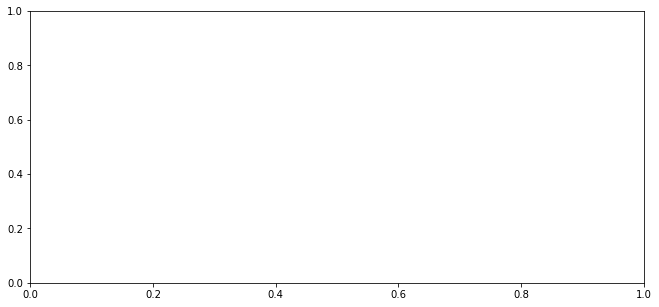

In [84]:
#total,BS = bases(50, 200, 100)
#número de UEs
max_UE = 4
N_ue = np.arange(max_UE)+1

#Calculando a capacidade de canal para UE recebendo sinal de todas as BS:
p = np.ones(max_UE)
p = p * inv_dbm(P_t)

fig, ax = plt.subplots(figsize = (11,5))
for num_ue in N_ue:
    C = np.zeros(mc)
    for k in range(mc):
        UE = usuário(num_ue, 200, 100)
        h = channel_user(N, UE, res, i)
        w = get_beamforming(h)
        SINR = sinr(h, w, j, i, σ)
        for SINRi in SINR:
            C[k] += np.log2(1+SINRi.mean())
    C = np.sort(C)# / num_ue
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    
    label = ('{} users'.format(num_ue))
    ax.plot(C, cdf_C, label=label)
    print('Average Channel Capacity for {} users: {} bits/Hz'.format(num_ue, average_C))
ax.set_ylabel("CDF")
ax.set_xlabel("Channel Capacity [bits/Hz]")
plt.legend()

In [10]:
n_ue = 4
p = np.ones(n_ue)
p = p * inv_db(P_t)
UE = usuário(n_ue, 200, 100)
SINR = compute_sinr(N, UE, BS, p, n_stream)
print('SINR: {}'.format(SINR))
SINR_mean = SINR[0].mean()
print('SINRmean: {}'.format(SINR_mean))

SINR: [[0.53878442 1.30153095 0.62102836]
 [0.62546247 0.72921625 1.00310427]
 [0.68964899 1.04231687 0.69224802]
 [0.7052931  0.70038512 0.51387591]]
SINRmean: 0.820447907679085
